# Parameter ID in a linear IVP

This demos the example in section 1.6.2 of Kelley. We want to identify unknown model parameters in the oscillator $u''+cu'+ku=0$, $u(0)=u_0$, $u'(0)=0$. We begin by generating some data from a known case.

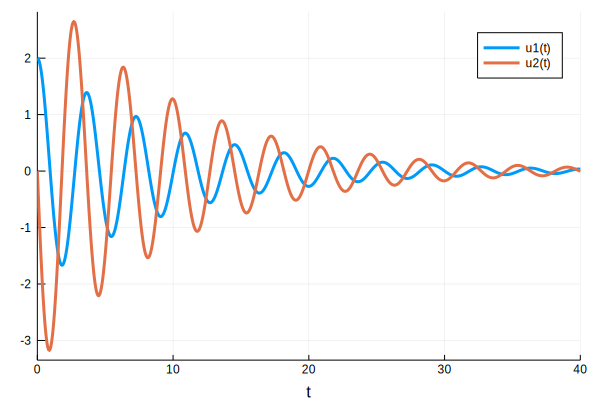

In [32]:
c = 0.2; k = 3; u0 = 2.; T = 40.;
using DifferentialEquations, Plots, LinearAlgebra
gr()

function SHO(ydot,y,p,t) 
    ydot[1] = y[2]
    ydot[2] = -p[1]*y[2]-p[2]*y[1]
end
y = solve( ODEProblem(SHO,[u0,0],(0.,T),[c,k]) )
plot(y,leg=true)

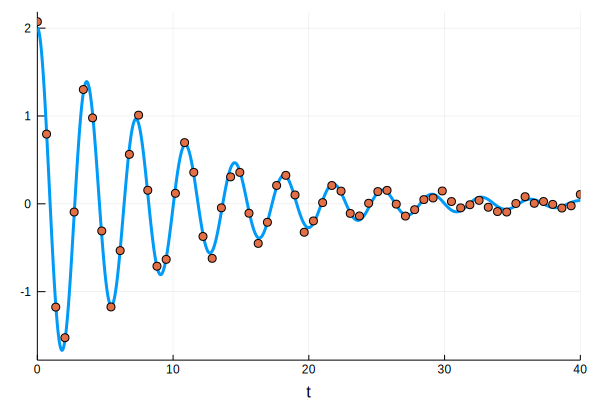

In [80]:
t = range(0,stop=T,length=60)
data = y.(t,idxs=1)
data += 0.04*randn(size(data))
plot(y,vars=[1])
scatter!(t,data,leg=false)

We now define a "misfit" function. For given parameter values, it computes the model solution, then defines a residual vector as the difference between model and data at all the times. It's the norm (squared) of this vector that will be the target of minimization.

In [81]:
function misfit(c,k)
    model = solve( ODEProblem(SHO,[u0,0],(0.,T),[c,k]) )
    return model.(t,idxs=1) - data
end

misfit (generic function with 1 method)

In [82]:
misfit(.05,2)

60-element Array{Float64,1}:
 -0.07352385082707702
  0.36486433235248616
  0.5514964740217279 
 -0.30088315359077233
 -1.3652423454996452 
 -1.1852266119974444 
  0.5633273527073169 
  1.938749988080466  
  1.5254501975164116 
 -0.6459206410480532 
 -2.2339055318144934 
 -1.758173057029403  
  0.614917587312555  
  ⋮                  
 -0.42277560315939977
 -0.8217457152089301 
 -0.5139560404754051 
  0.24579082416148768
  0.7499748299705861 
  0.6232489994647779 
  0.06170943624392888
 -0.6312773342205015 
 -0.7424159713423377 
 -0.21276739416839444
  0.452018999810254  
  0.6298445594654484 

Since there are only two parameters, it's not hard to do a brute force computation to get a feeling for the misfit.

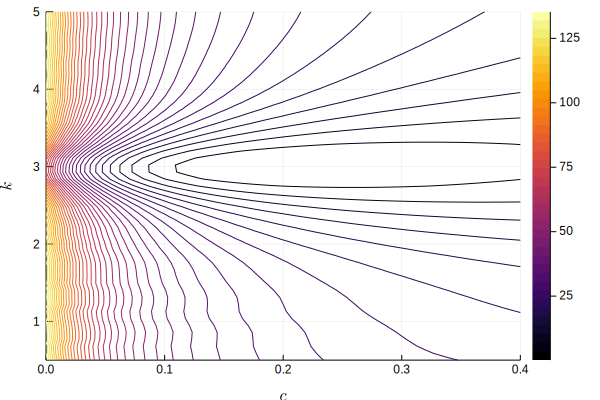

In [83]:
cval = range(0.,stop=0.4,length=51)
kval = range(0.5,stop=5,length=51)
contour(cval,kval,(c,k)->norm(misfit(c,k))^2,levels=40,xaxis="c",yaxis="k")

It looks like the misfit is much more sensitive to $k$ than to the damping $c$.

In [84]:
using Optim
objective = x->norm(misfit(x[1],x[2]))^2/2
optimize(objective,[1.,1.])

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [1.0,1.0]
 * Minimizer: [0.19760251746612634,2.994213690667698]
 * Minimum: 6.396328e-02
 * Iterations: 35
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 70

That actually did a nice job at recovering the true values of $c=0.2$, $k=3$. It used an algorithm that avoids taking derivatives with respect to the parameters. We can force it to try something different.

In [85]:
optimize(objective,[1.,1.],BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [1.0,1.0]
 * Minimizer: [0.1976127769465025,2.9942052620034914]
 * Minimum: 6.396326e-02
 * Iterations: 14
 * Convergence: false
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 2.66e-10 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 2.47e-11 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 3.30e-08 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 60
 * Gradient Calls: 60

That's pretty reassuring. Note that each "objective call" here requires a numerical solution of the model IVP. In general that work needs to be minimized. 

Suppose you wanted $k$ and $c$ to vary with time, and to search over all pointwise values of them at the 60 time steps we chose. Then you're optimizing in a 120-dimensional space, which is a different ballgame altogether. (There isn't nearly enough data here to do that well.) 